In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
import functools
import logging
import numpy as np
import os
import quantities as pq

import epych
from epych.statistics import alignment

[striatum:554391] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/792068096/shared_mem_cuda_pool.striatum could be created.
[striatum:554391] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Adapted": (ADAPTED_ONSET.magnitude, 'lightgreen'),
    "Adapted Offset": (ADAPTED_OFFSET.magnitude, 'red'),
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]
CONDITION_TITLES = {
    "lonaive": "Local Oddball Cue Trials",
    "go_gloexp": "Global Oddball",
    "go_seqctl": "AAAA Control",
    "lo_gloexp": "Local Oddball",
    "lo_rndctl": "AAAB Random",
    "igo_seqctl": "BBBB Control"
}

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def condition_stattitle(cond, name, stat):
    return stattitle(name, stat) + (" (%s)" % CONDITION_TITLES[cond])

In [10]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [11]:
summaries = {}

In [12]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_spectrogram_downsample16_wavelet_%s" % cond
    summaries[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


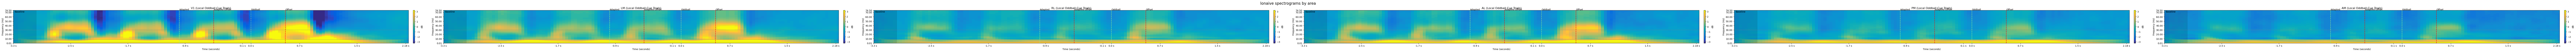

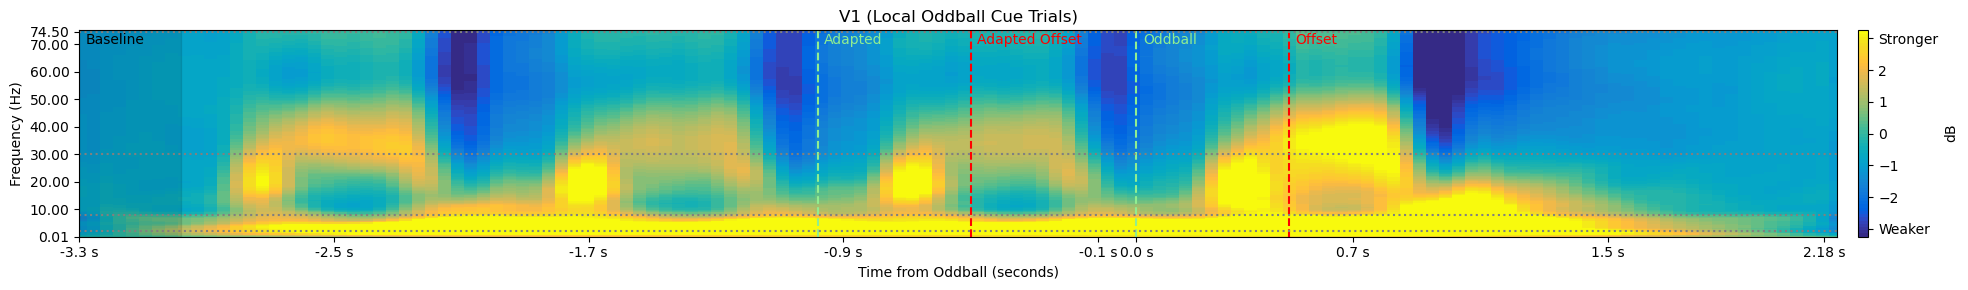

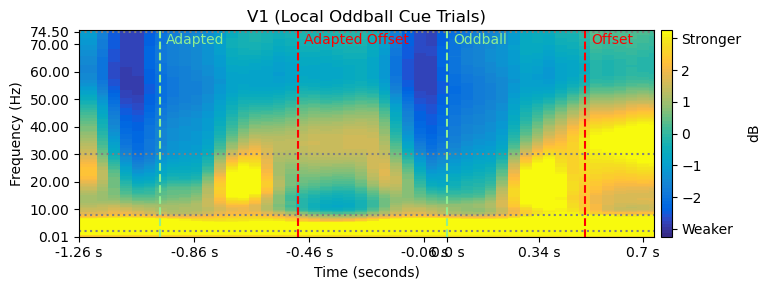

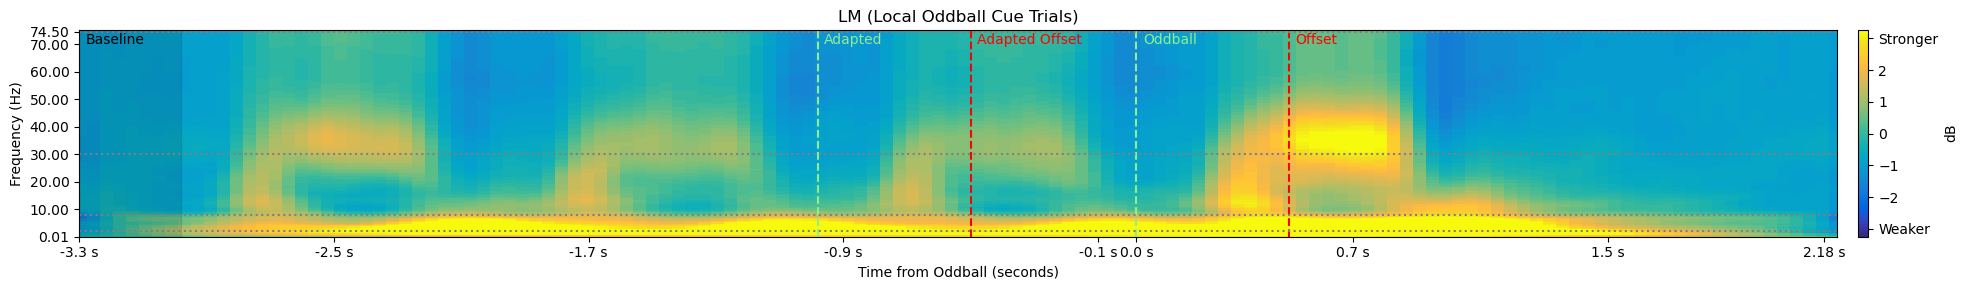

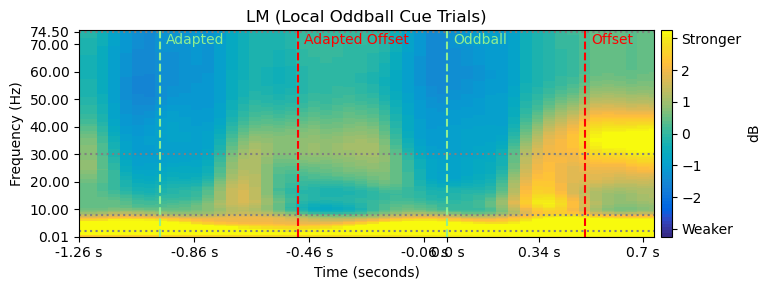

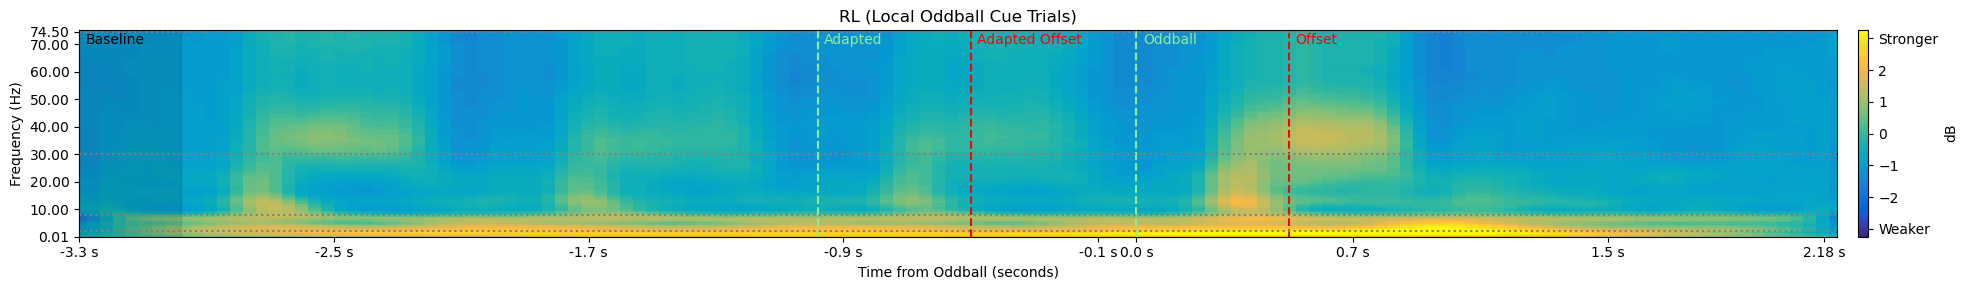

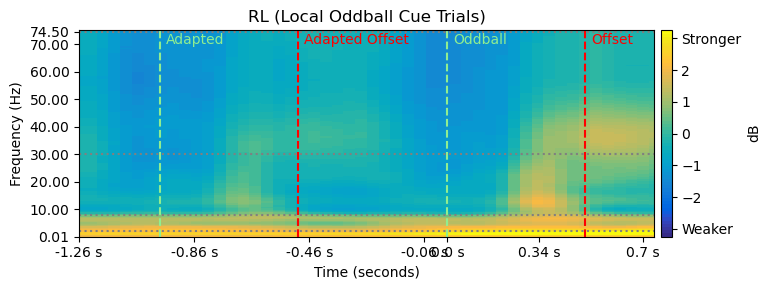

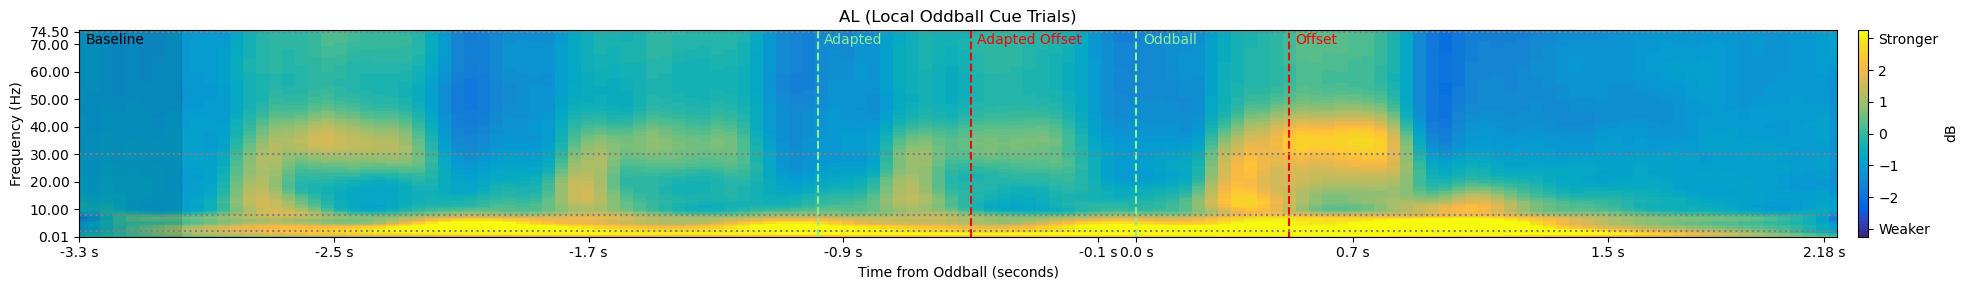

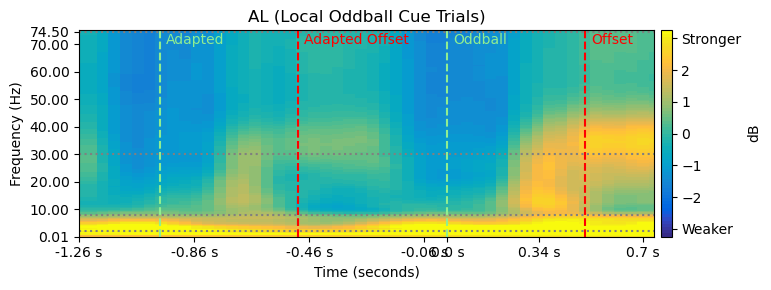

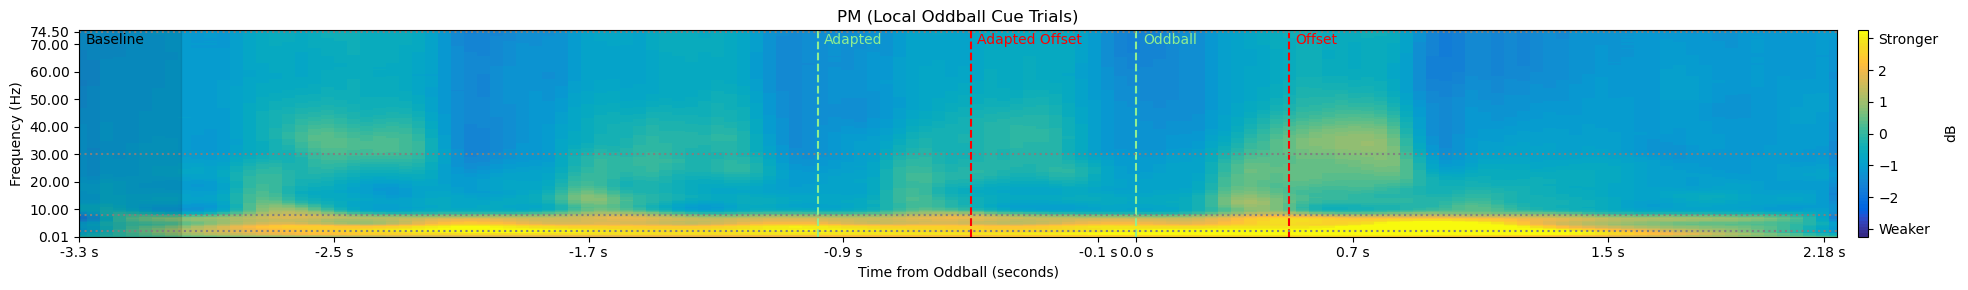

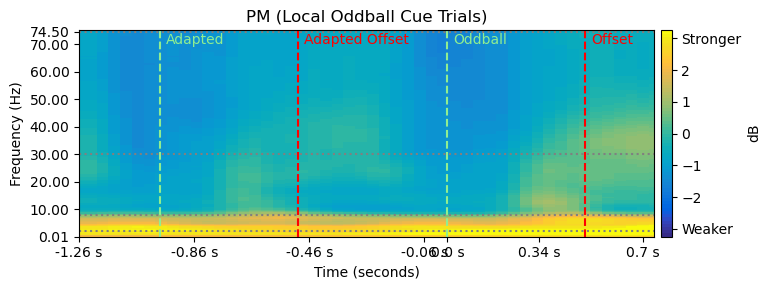

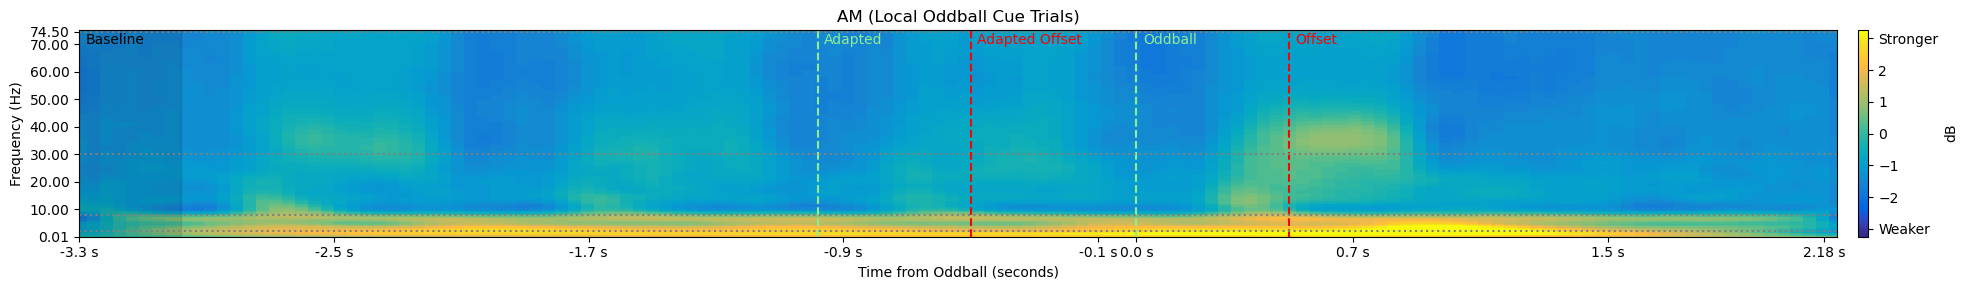

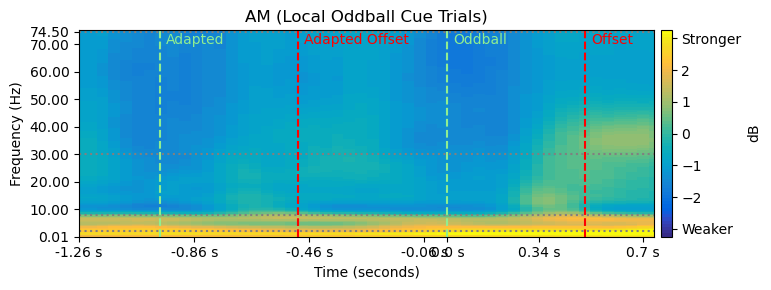

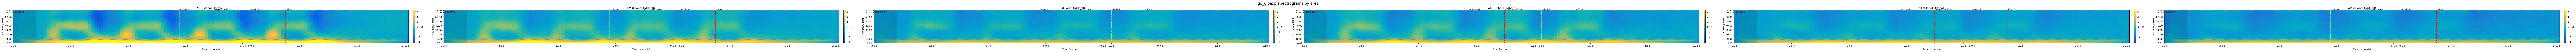

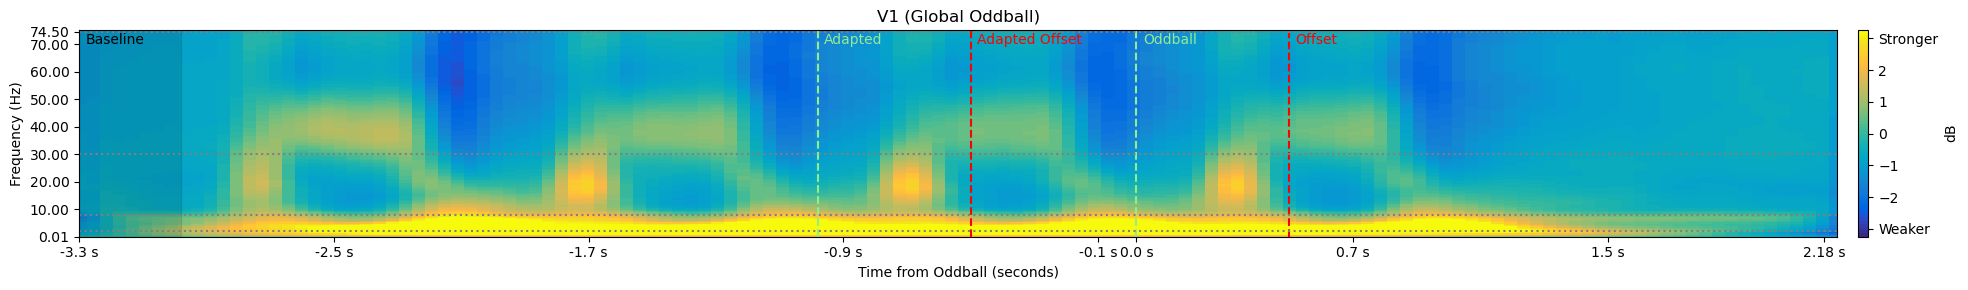

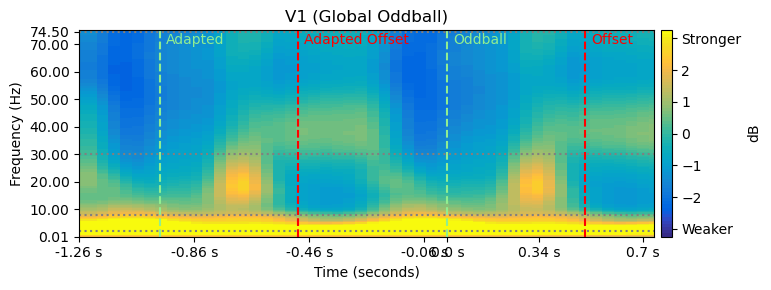

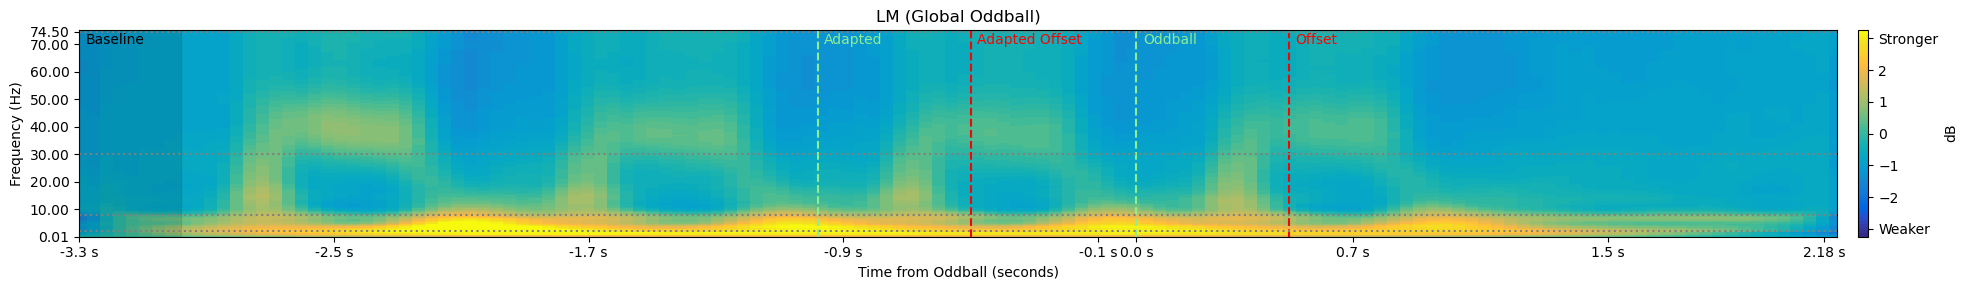

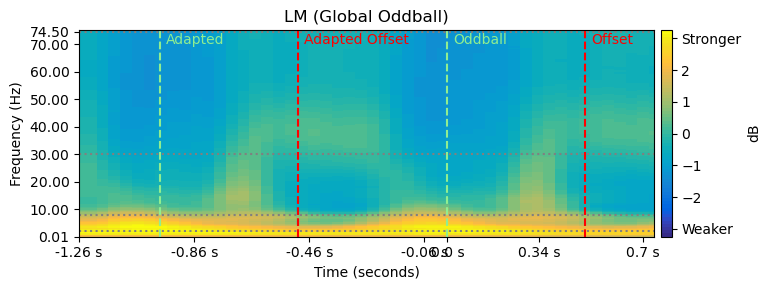

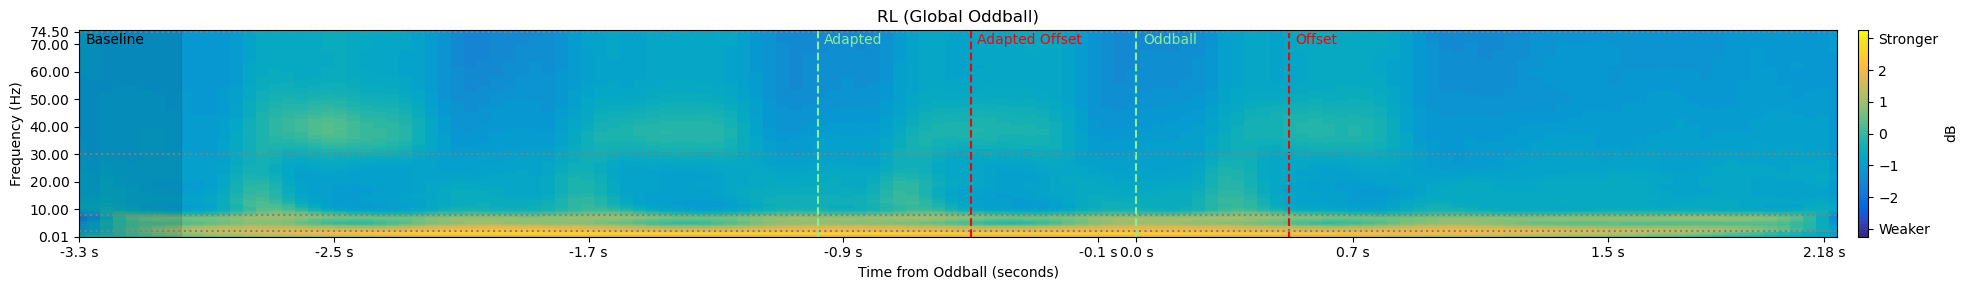

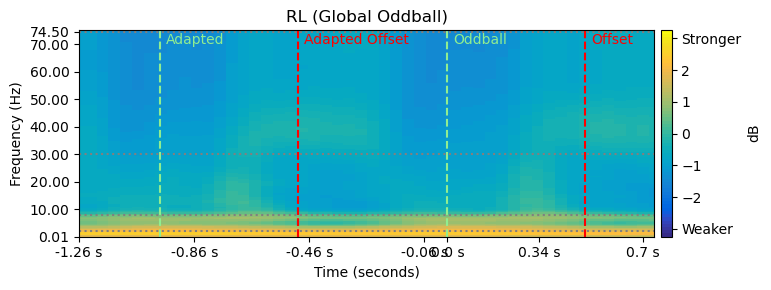

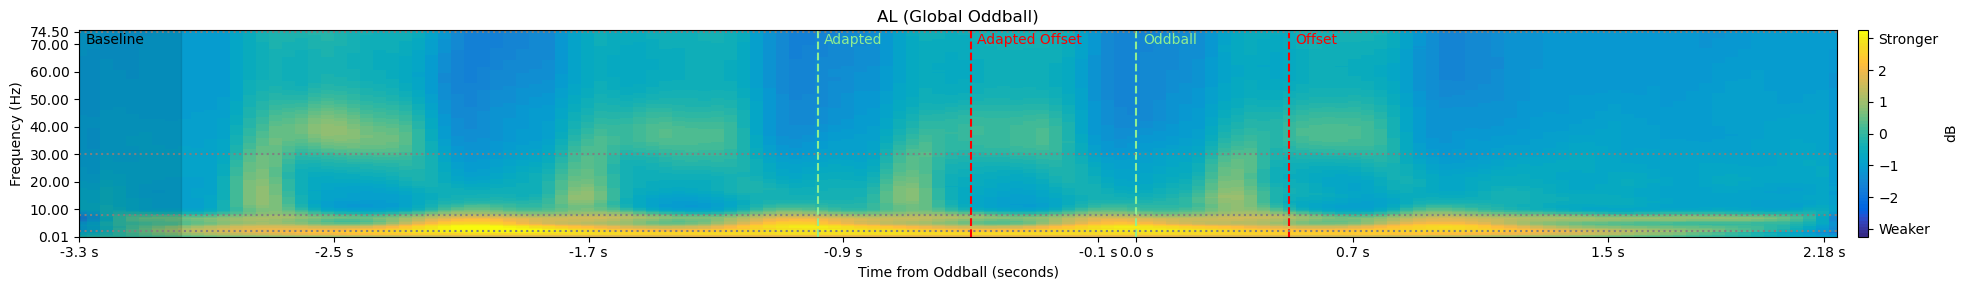

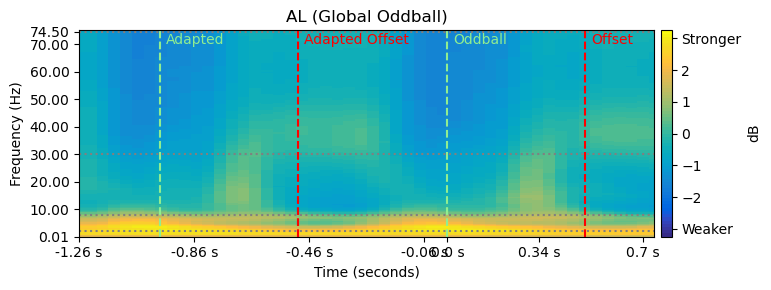

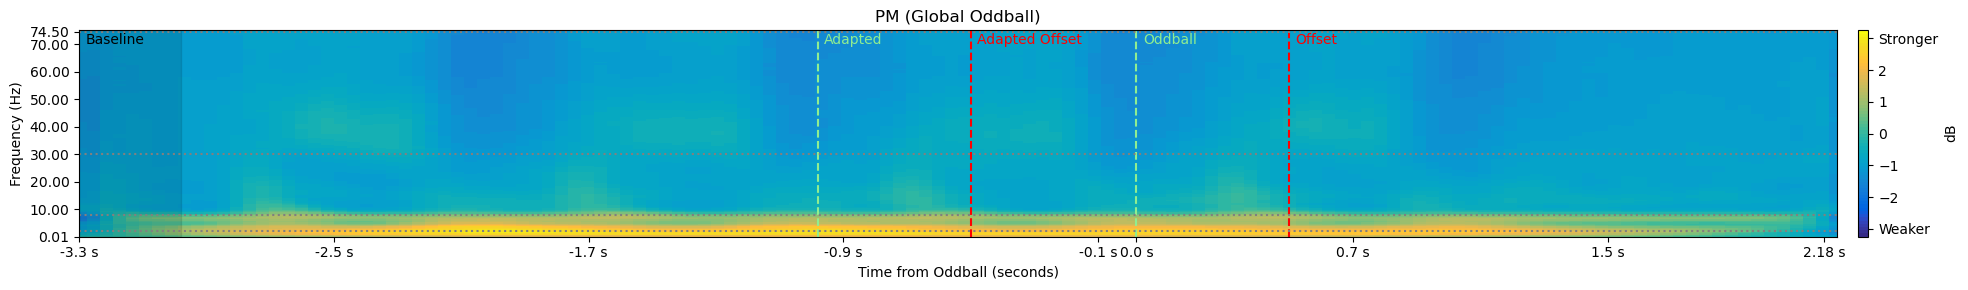

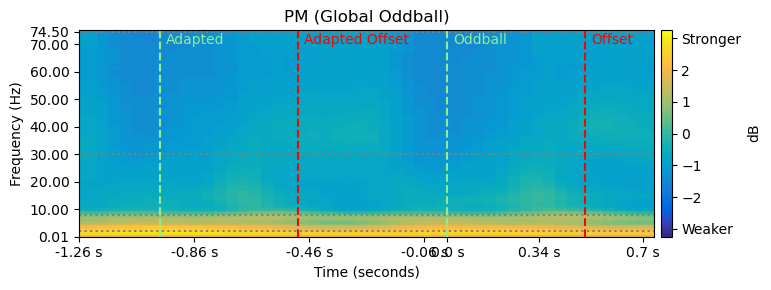

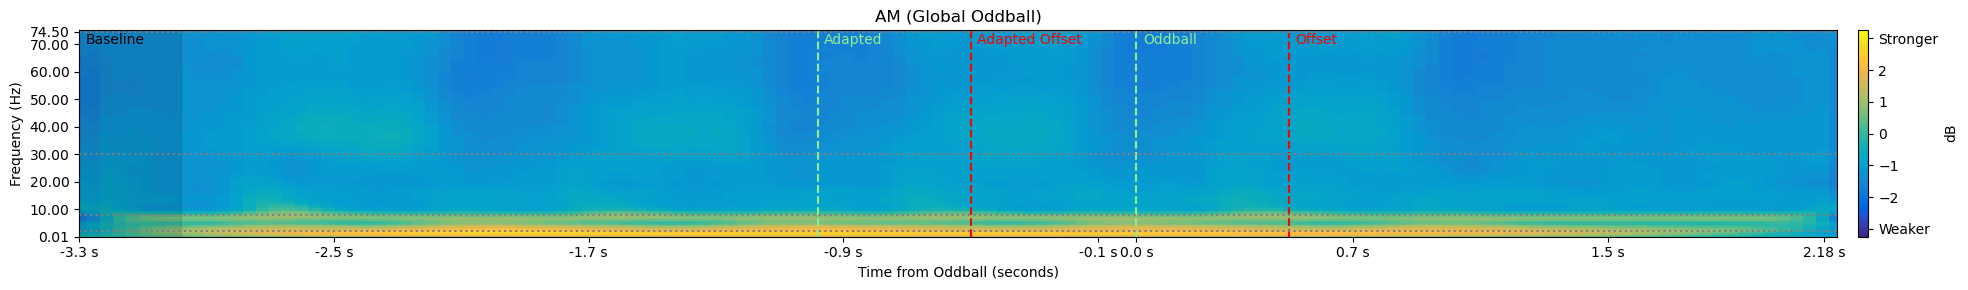

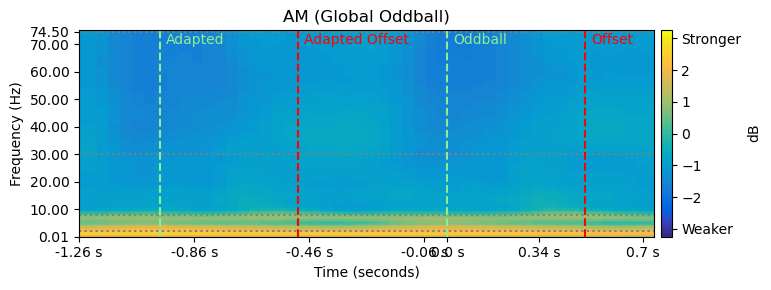

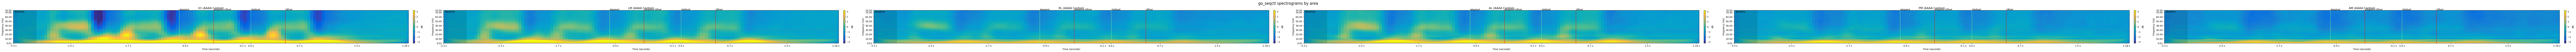

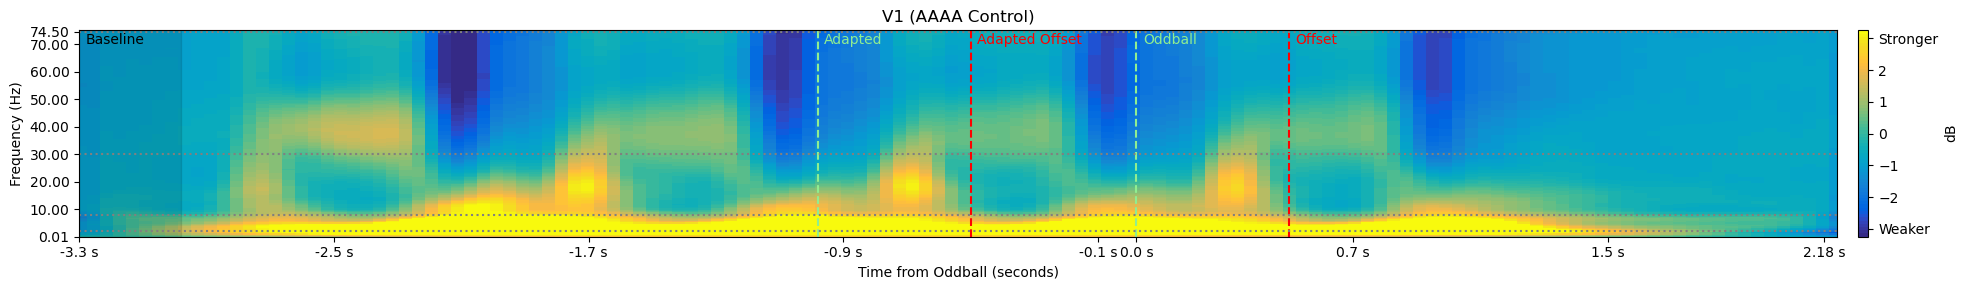

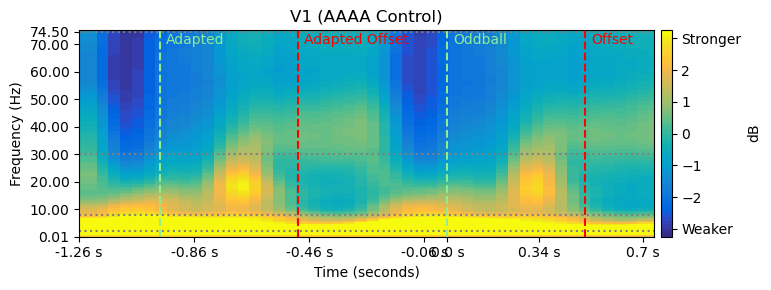

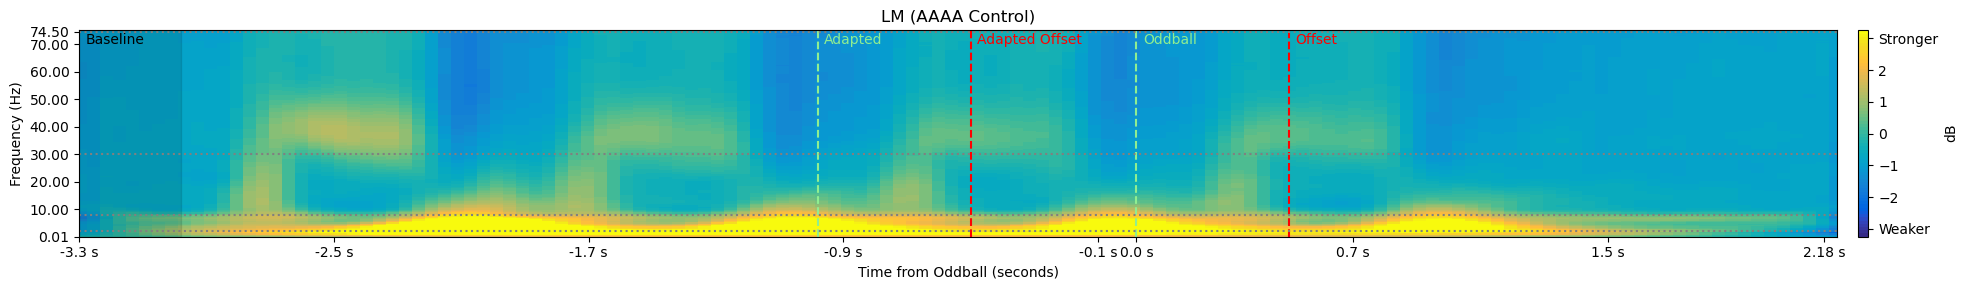

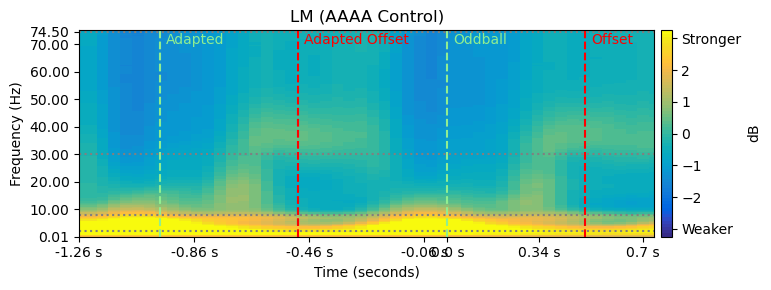

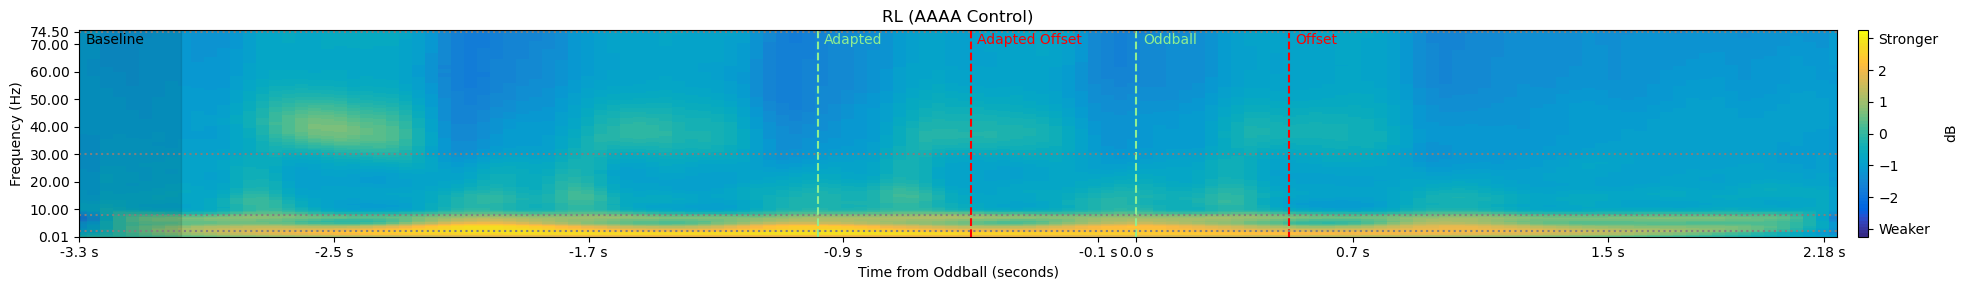

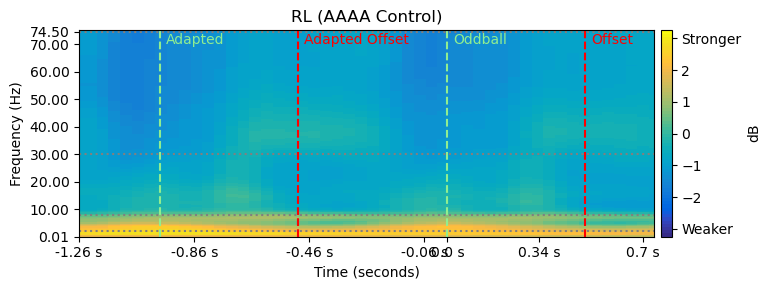

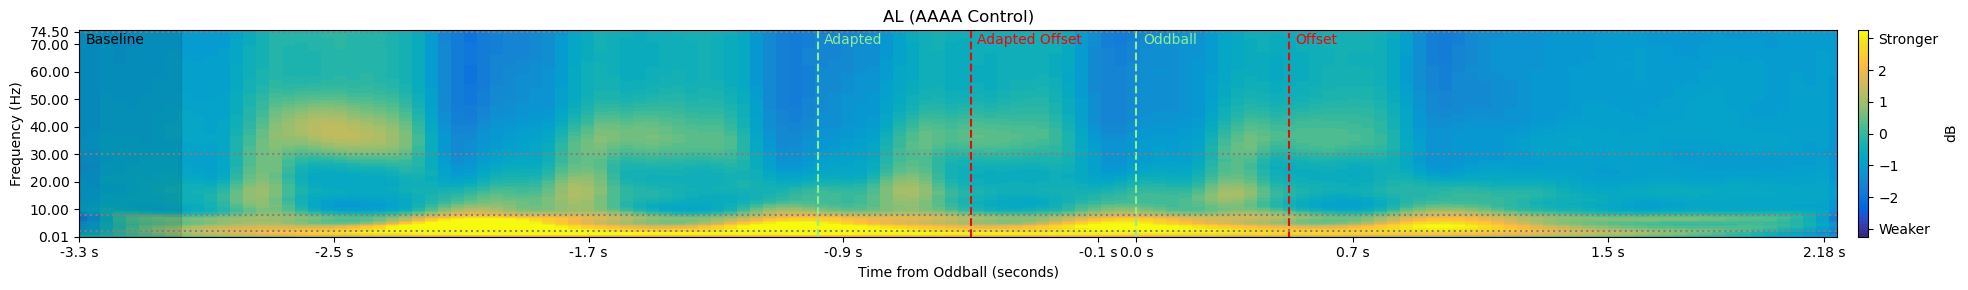

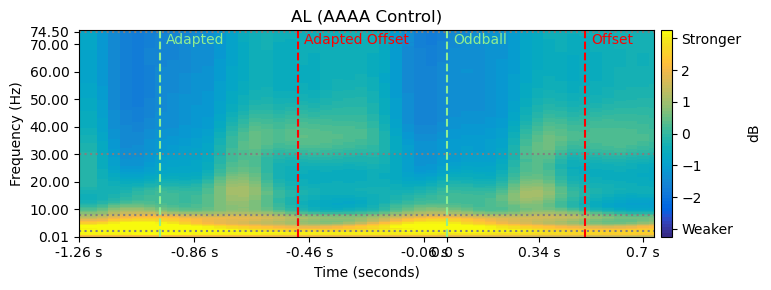

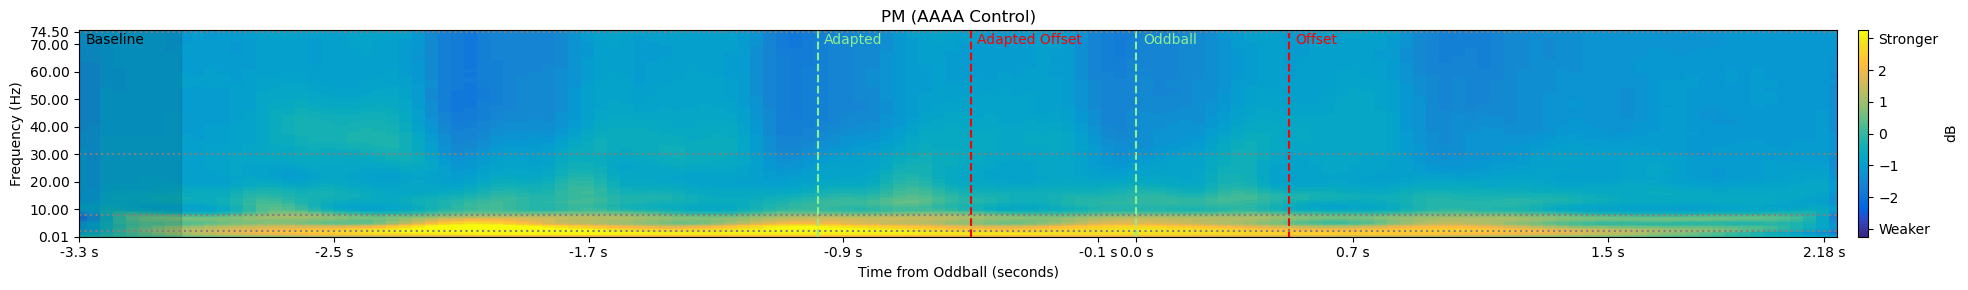

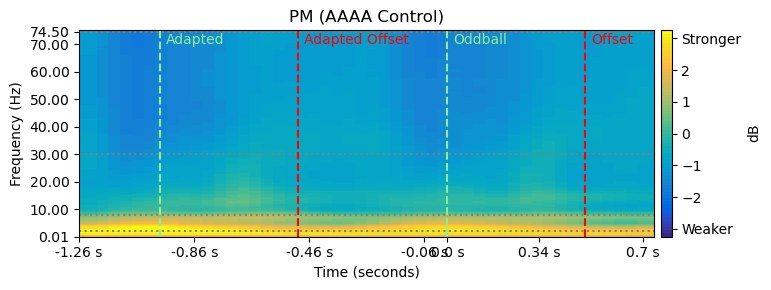

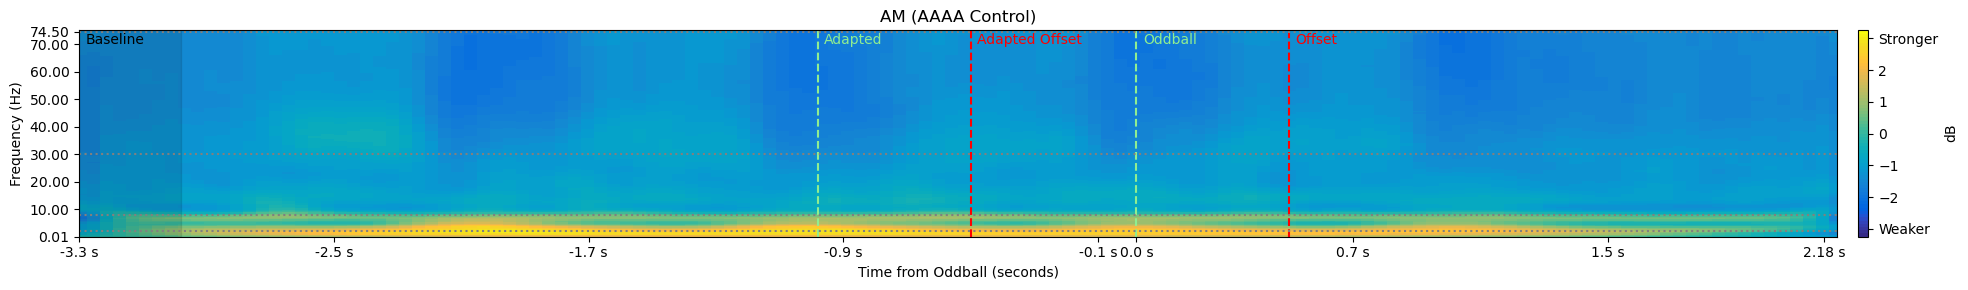

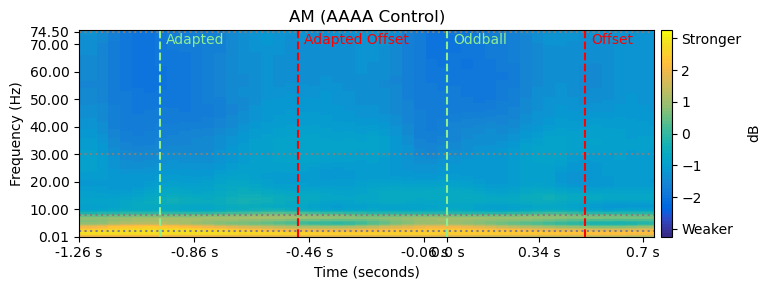

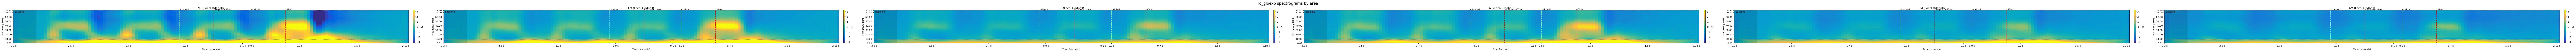

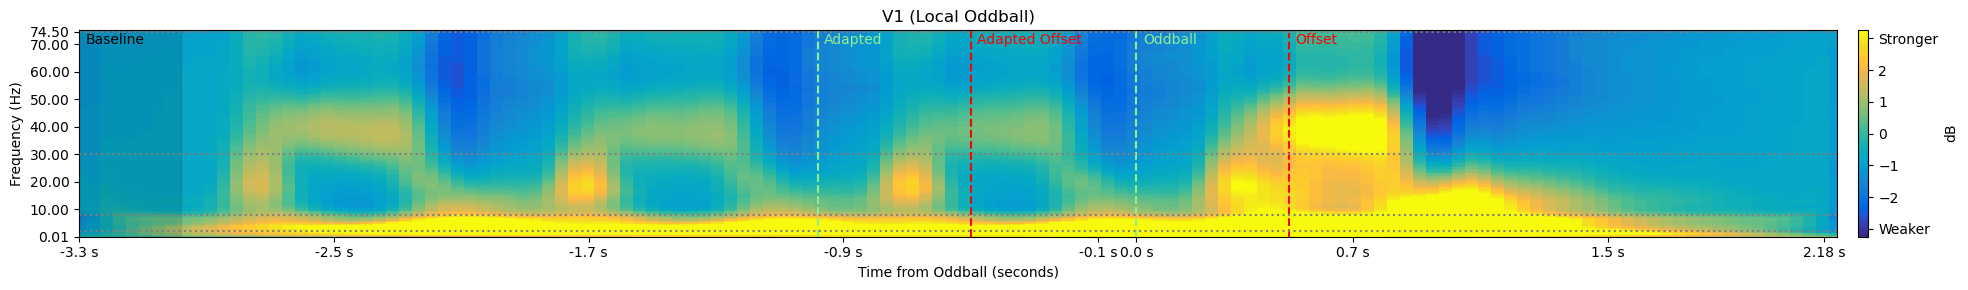

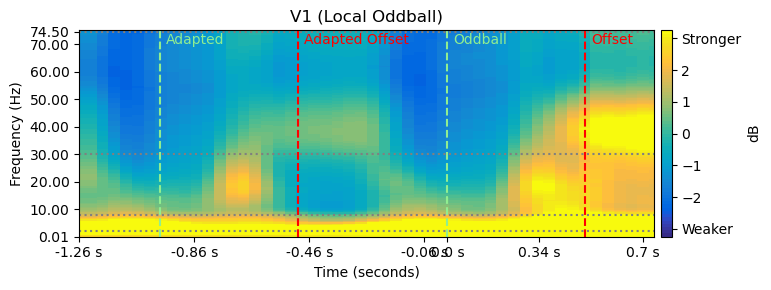

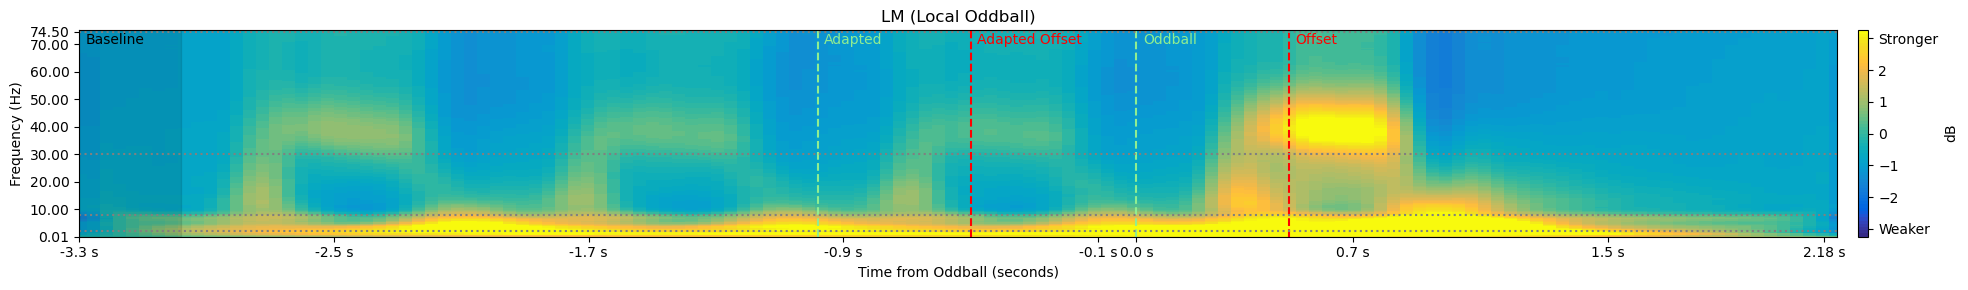

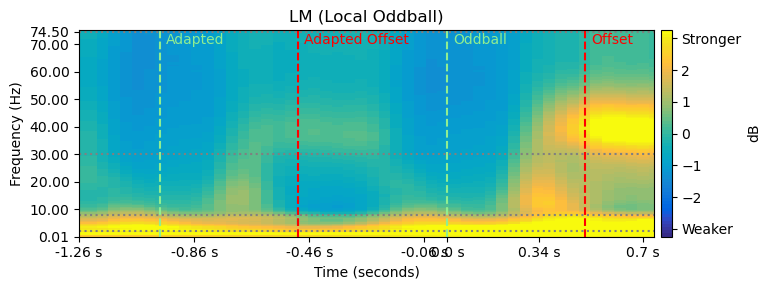

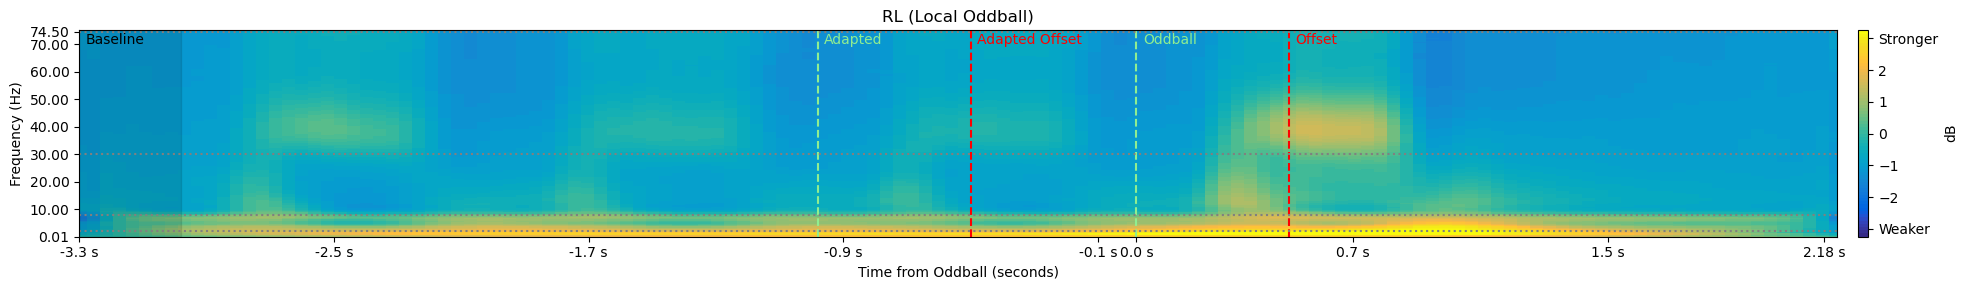

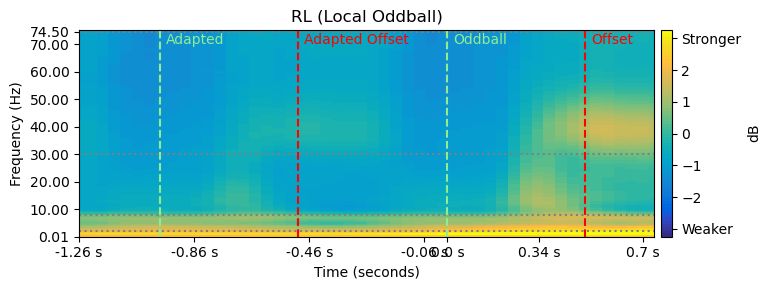

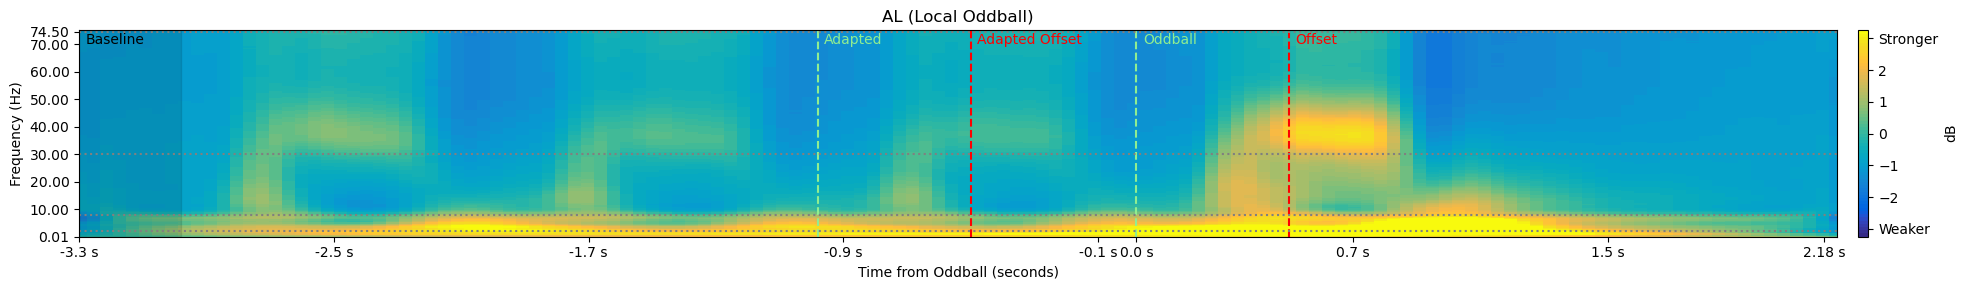

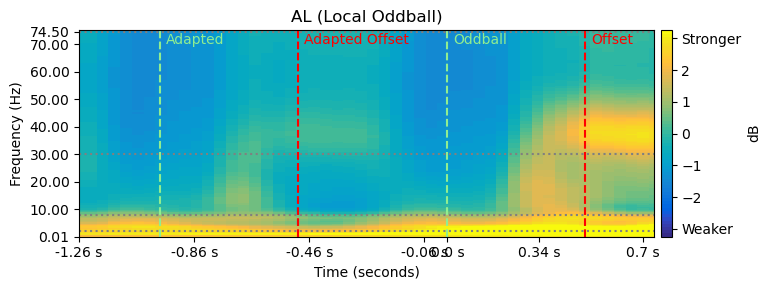

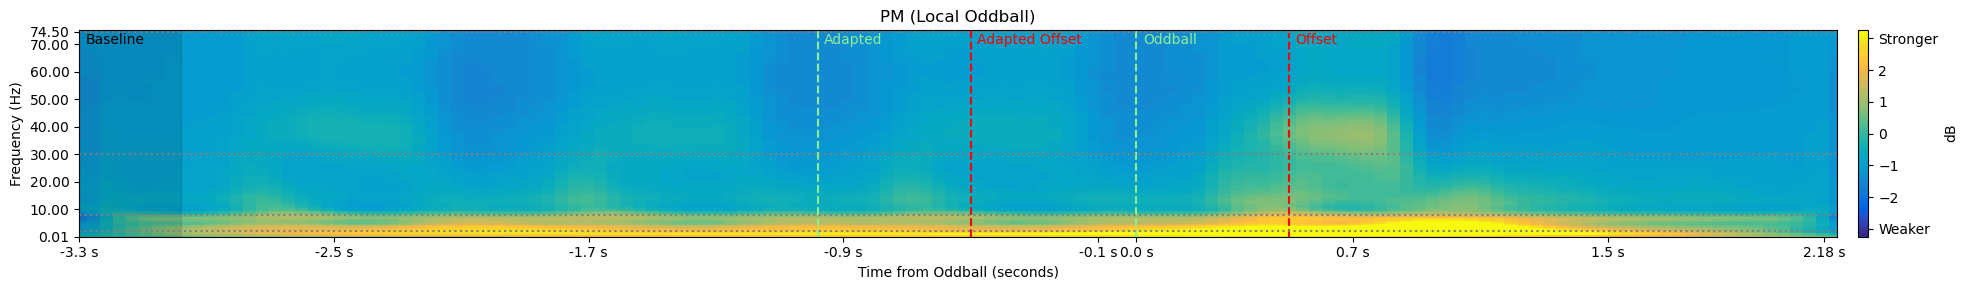

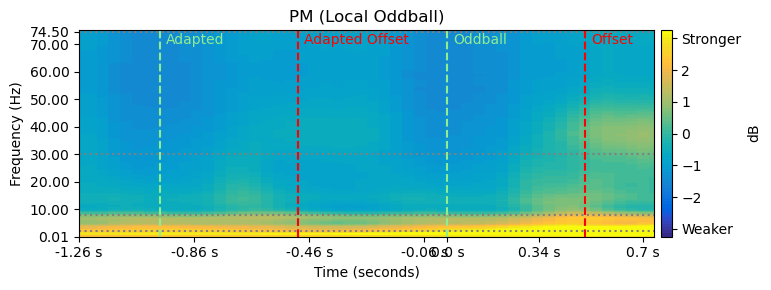

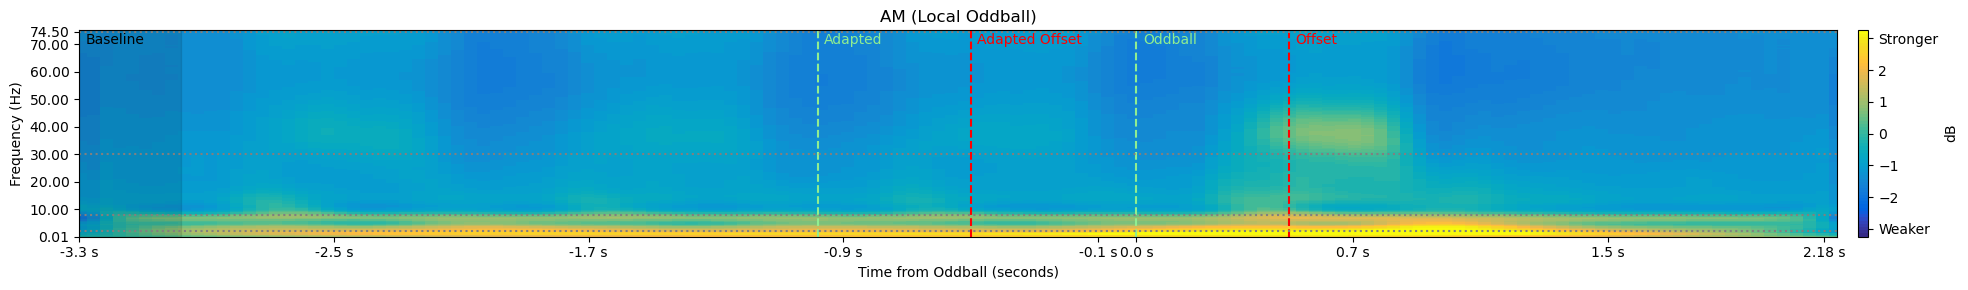

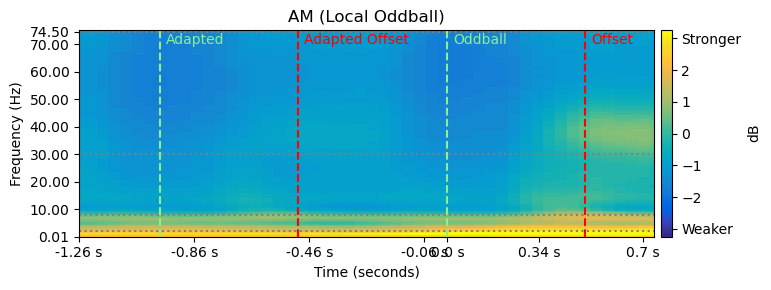

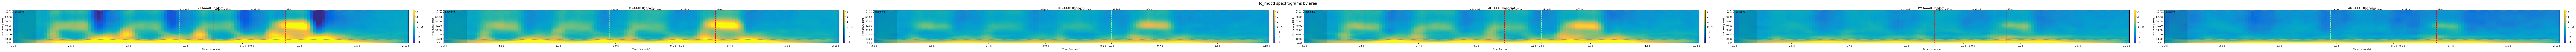

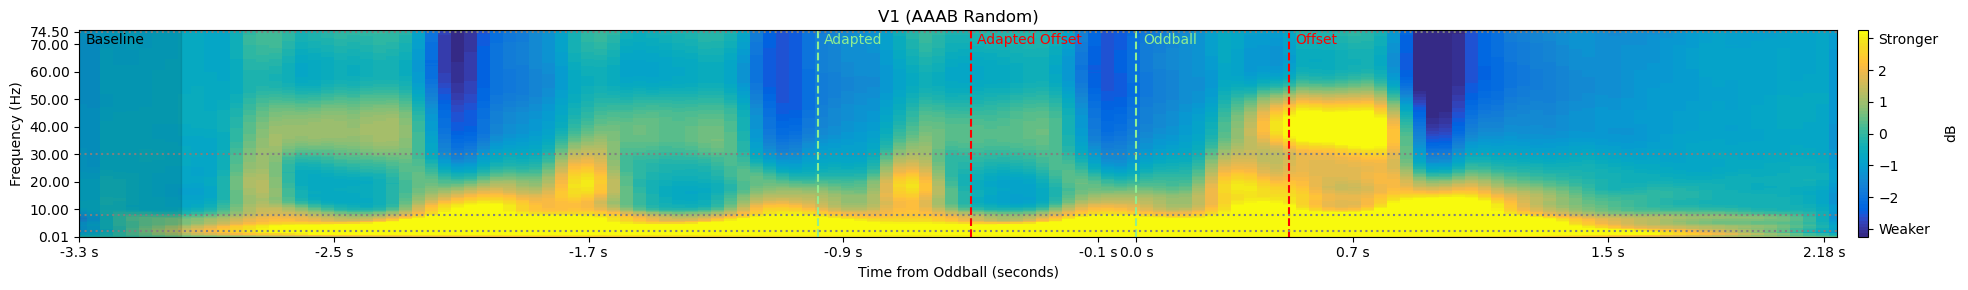

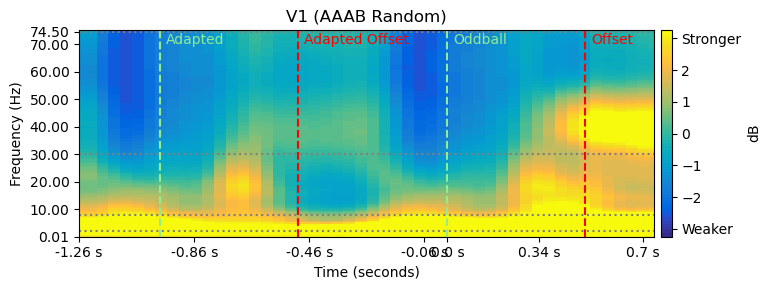

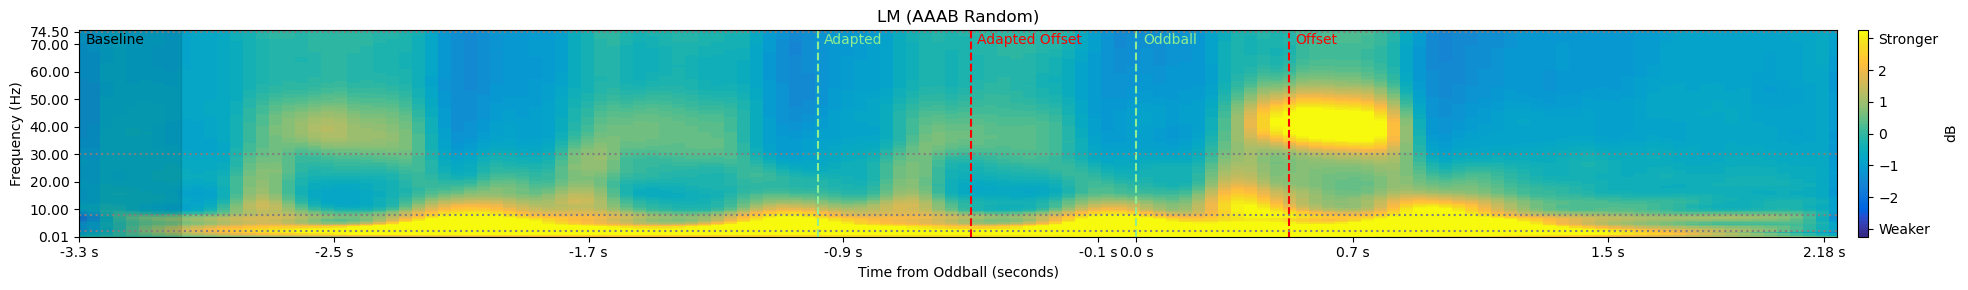

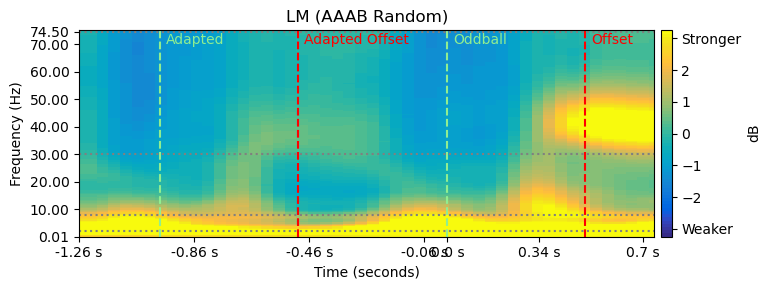

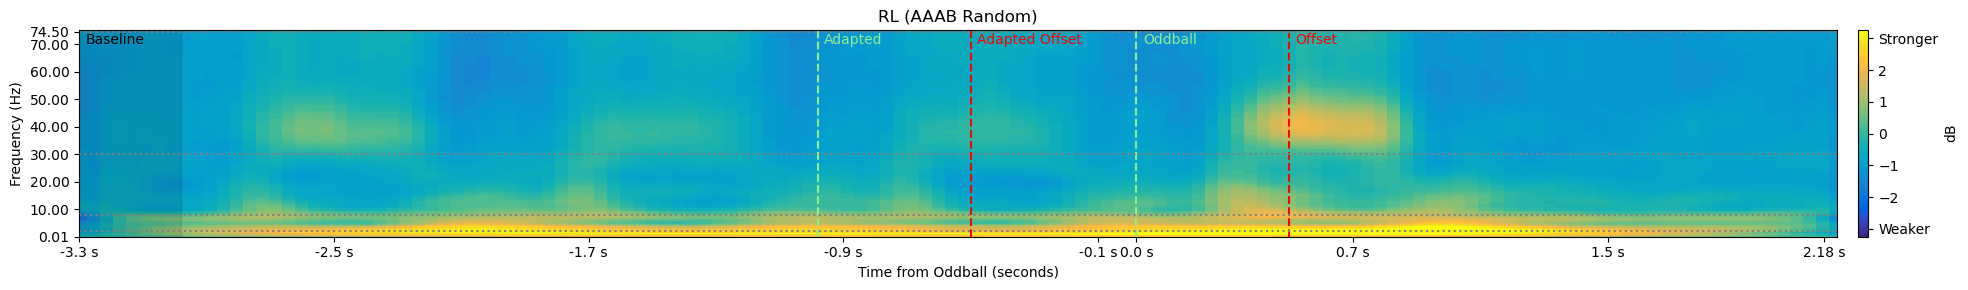

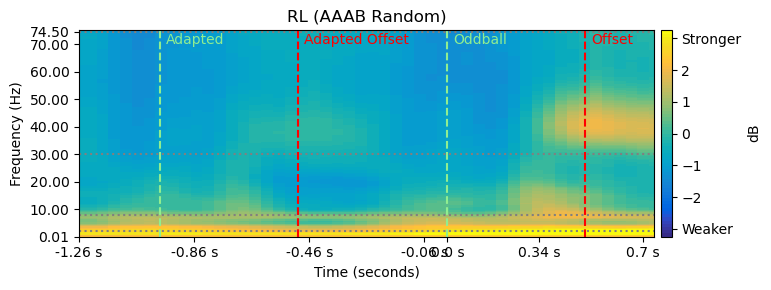

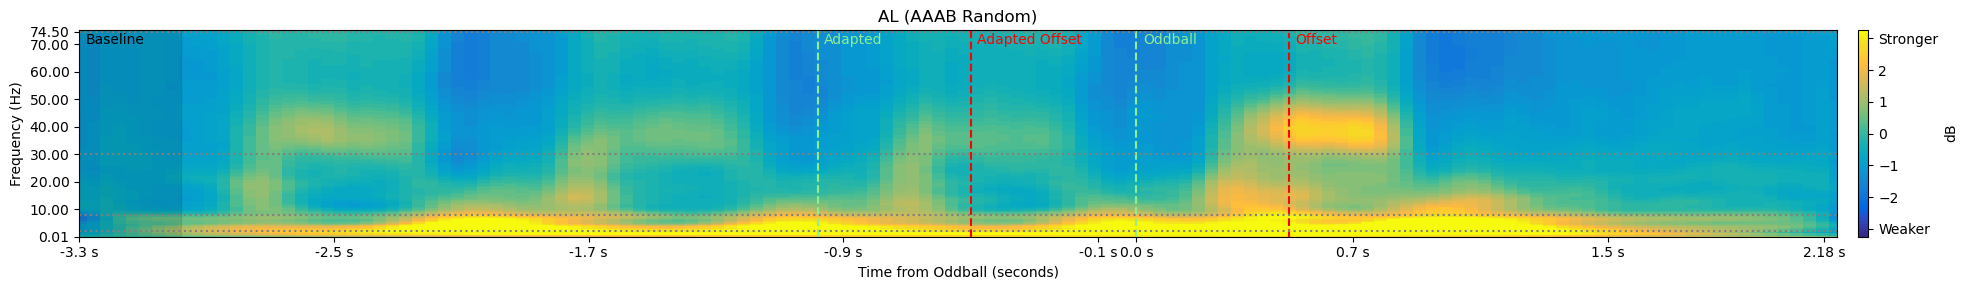

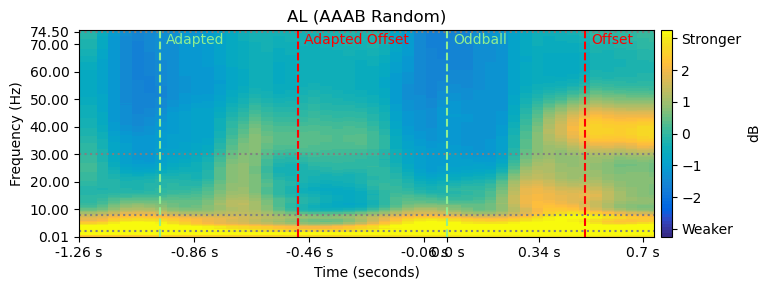

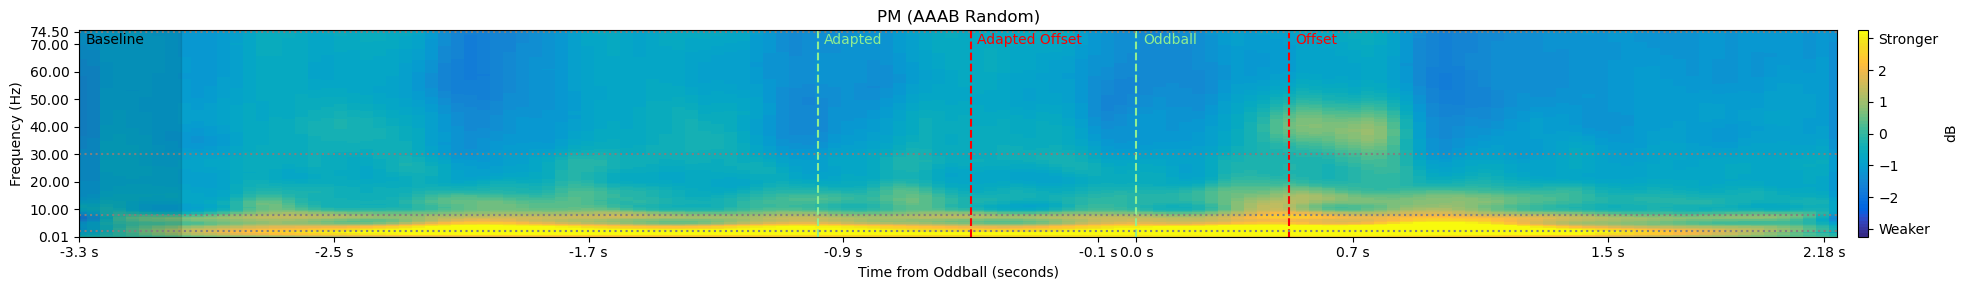

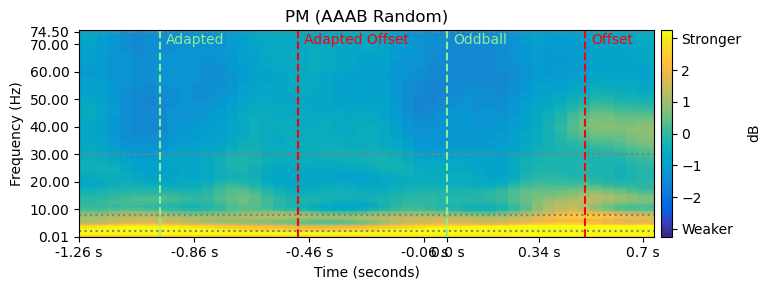

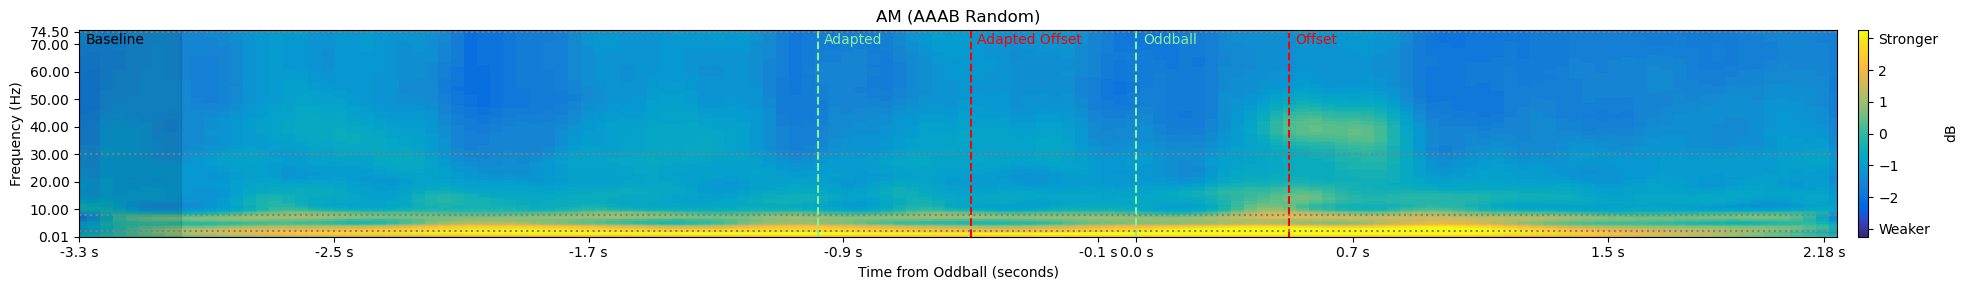

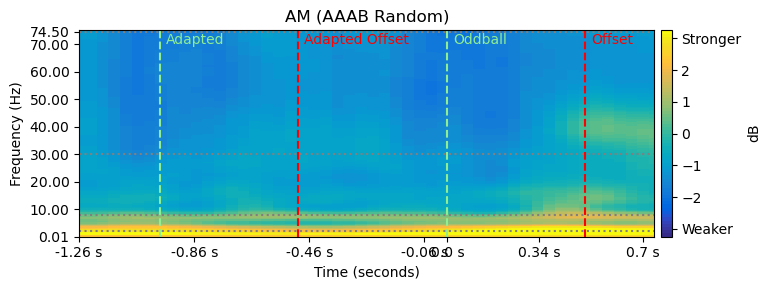

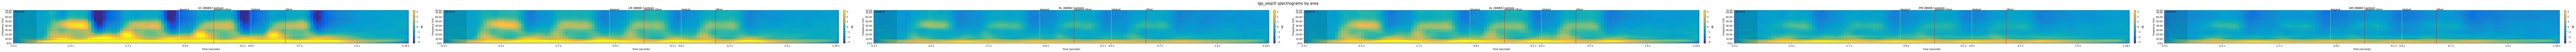

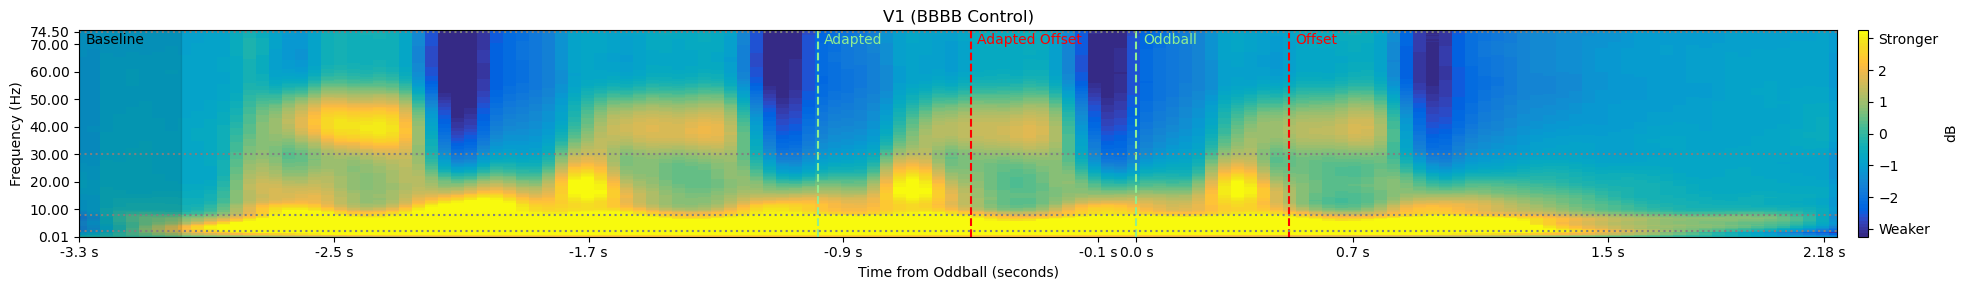

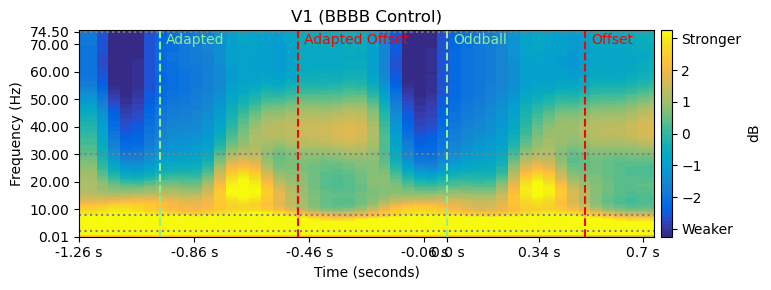

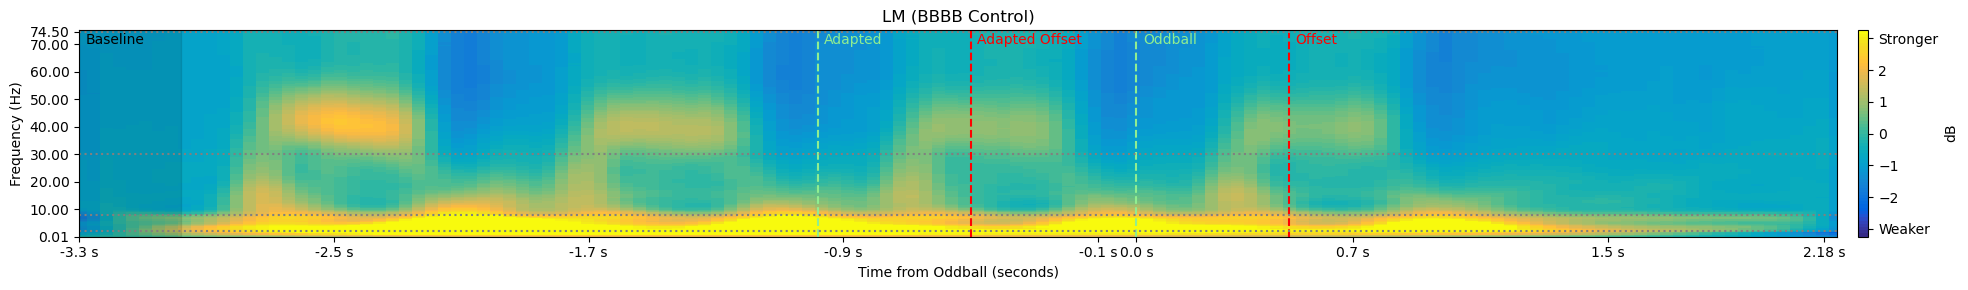

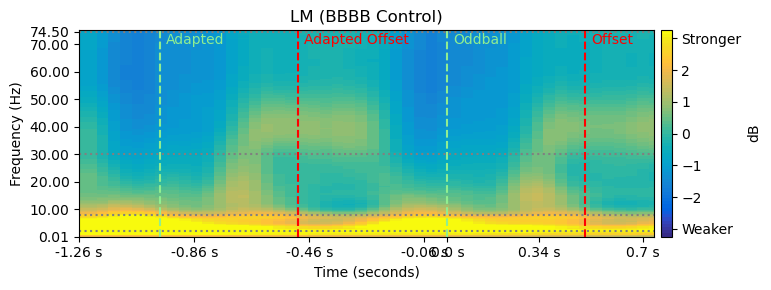

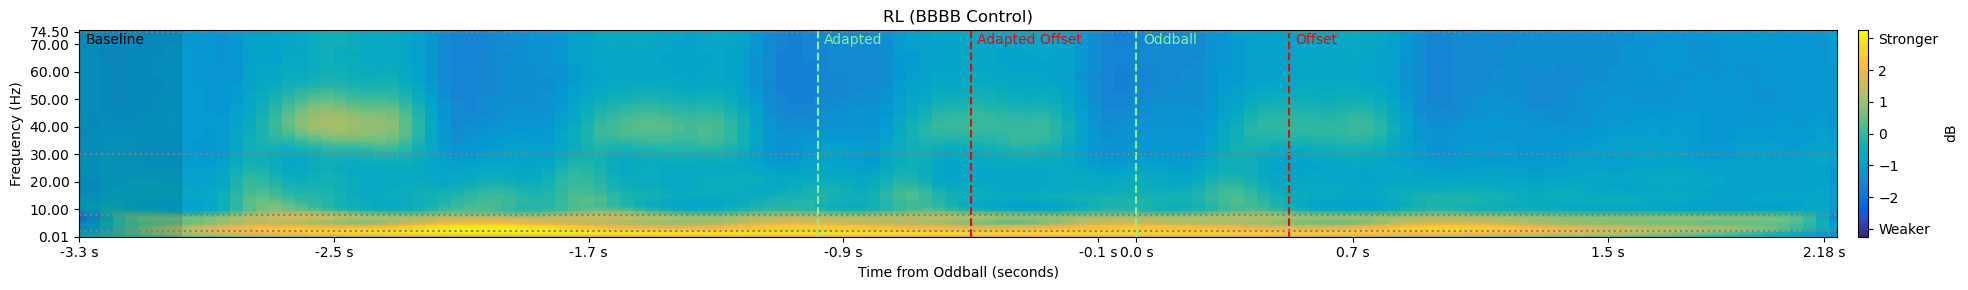

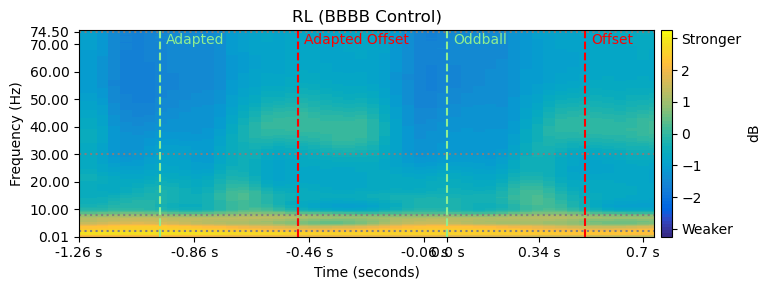

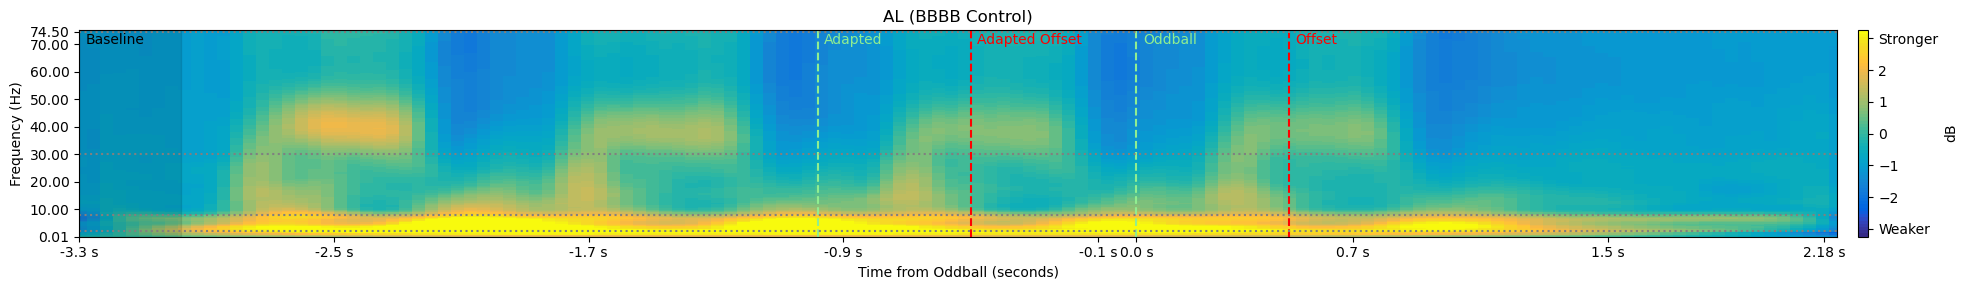

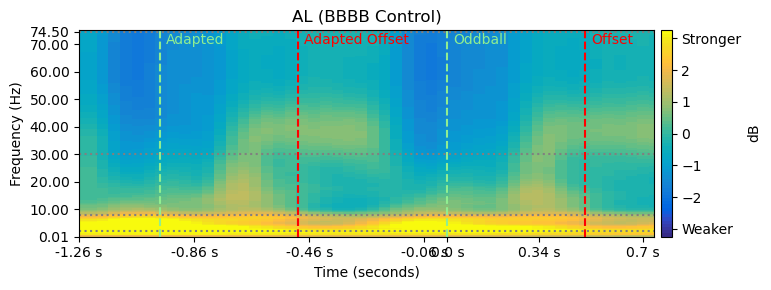

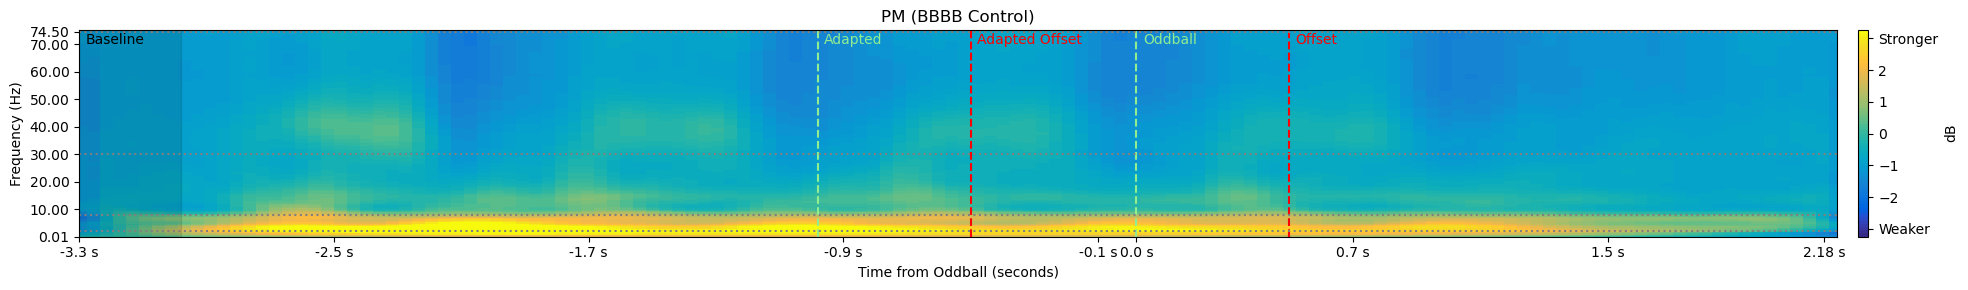

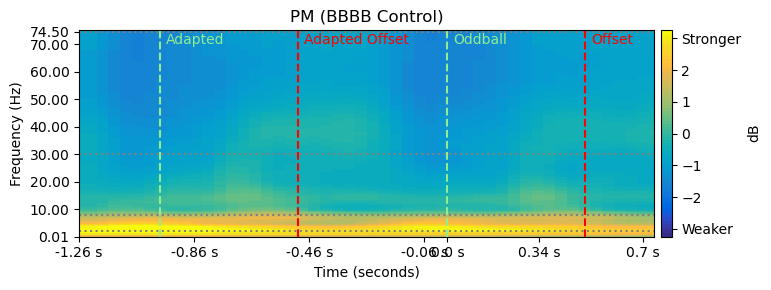

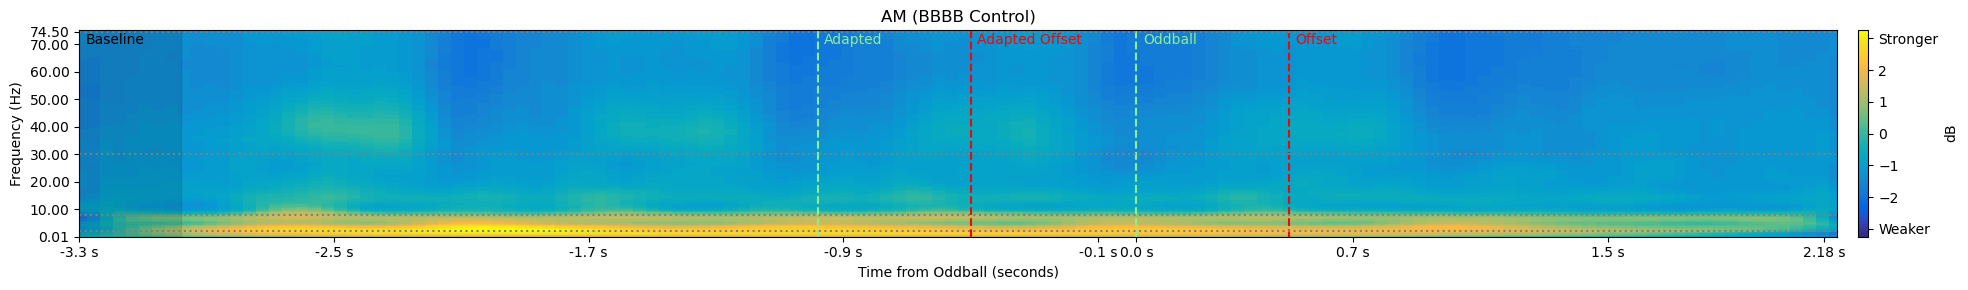

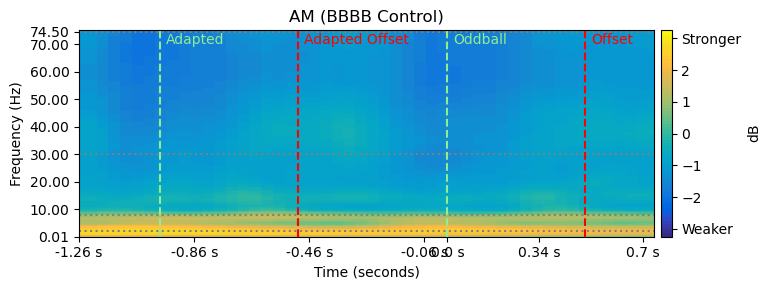

In [13]:
for cond in CONDITIONS:
    cond_stattitle = functools.partial(condition_stattitle, cond)
    tfrs = summaries[cond].results().smap(lambda tfr: tfr.channel_mean().baseline(-3.5 * pq.second, -3.0 * pq.second, decibels=True).select_freqs(0, 75)).erp()
    tfrs.plot(signals=anatomical_areas, sigtitle=cond_stattitle, title="%s spectrograms by area" % cond, vmin=-3.25, vmax=3.25, baseline=(-3.5, -3.0),
              figure="grand_spectrogram_downsample16_%s.pdf" % cond, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("grand_spectrogram_downsample16_%s/" % cond, exist_ok=True)
        tfrs.signals[area].plot(title=cond_stattitle(area, tfrs.signals[area]), filename="grand_spectrogram_downsample16_%s/%s.pdf" % (cond, area), vmin=-3.25, vmax=3.25,
                                baseline=(-3.5, -3.0), cbar_ends=("Stronger", "Weaker"), tlabel="Time from Oddball (seconds)", **EVENTS)
        oddball_signal = tfrs.signals[area][ADAPTED_ONSET.magnitude - 0.25:ODDBALL_OFFSET.magnitude + 0.25]
        oddball_signal.plot(title=cond_stattitle(area, tfrs.signals[area]), vmin=-3.25, vmax=3.25,
                                                 filename="grand_spectrogram_downsample16_%s/%s_oddball.pdf" % (cond, area), cbar_ends=("Stronger", "Weaker"), **EVENTS)